In [110]:
from transformers import GPT2Tokenizer, GPTNeoForCausalLM
from transformers import pipeline
import torch
import os
import numpy as np
from tqdm import tqdm
import csv
%matplotlib inline

In [2]:
tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-2.7B")
model = GPTNeoForCausalLM.from_pretrained("EleutherAI/gpt-neo-2.7B")


In [3]:
device = torch.device('cuda:0')
model.to(device)

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 2560)
    (wpe): Embedding(2048, 2560)
    (drop): Dropout(p=0, inplace=False)
    (h): ModuleList(
      (0): GPTNeoBlock(
        (ln_1): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0, inplace=False)
            (resid_dropout): Dropout(p=0, inplace=False)
            (k_proj): Linear(in_features=2560, out_features=2560, bias=False)
            (v_proj): Linear(in_features=2560, out_features=2560, bias=False)
            (q_proj): Linear(in_features=2560, out_features=2560, bias=False)
            (out_proj): Linear(in_features=2560, out_features=2560, bias=True)
          )
        )
        (ln_2): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=2560, out_features=10240, bias=True)
          (c_proj): Linear(in_fe

In [ ]:
class MeanReciprocalRank:
    def __init__(self):
        self._sum = 0.0
        self._n = 0.0

    def __call__(self, predictions, labels):
        # Flatten
        labels = labels.view(-1)
        
        predictions = predictions.view(labels.shape[0], -1)

        
        # MRR computation
        label_scores = predictions.gather(-1, labels.unsqueeze(-1))
        rank = predictions.ge(label_scores).sum(1).float()
        # print(rank)
        reciprocal_rank = 1 / rank
        self._sum += (reciprocal_rank).sum().item()
        self._n += len(labels)

    def get_metric(self, reset=False):
        mrr = self._sum / (self._n + 1e-13)
        if reset:
            self.reset()
        return mrr
    def reset(self):
        self._sum = 0.0
        self._n = 0.0
class Hits:
    def __init__(self, topn):
        self.topn = topn
        self._sum = 0.0
        self._n = 0.0

    def __call__(self, predictions, labels):
        # Flatten
        labels = labels.view(-1)

        predictions = predictions.view(labels.shape[0], -1)


        # MRR computation
        label_scores = predictions.gather(-1, labels.unsqueeze(-1))
        rank = predictions.ge(label_scores).sum(1).float()
        # reciprocal_rank = 1 / rank
        score = rank.le(self.topn).float()
        self._sum += (score).sum().item()
        self._n += len(labels)

    def get_metric(self, reset=False):
        hits = self._sum / (self._n + 1e-13)
        if reset:
            self.reset()
        return hits

    def reset(self):
        self._sum = 0.0
        self._n = 0.0


In [105]:
import datetime
import csv
s_list = []
birth_property = "place"
with open('birth_table1.tsv', 'r') as t:
    i = 0
    # sentences_birth = open("sentences_birth.tsv", "w")
    # tsv_writer = csv.writer(sentences_birth, delimiter='\t')

    for line in t:
        i+=1
        if i==1:
            continue
        
        person, mother, place, date = line.split('\t')
        if len(mother) == 0:
            continue
        def process(raw):
            raw = raw.split("@")
            content, lang = raw
            content = content.strip("''").split()
            return content, lang

        person, lang = process(person)
        if lang != "en":
            continue
        mother, lang = process(mother)
        if lang != "en":
            continue        
        place, lang = process(place)
        if lang != "en":
            continue
        
        date = date.split('T')[0][1:]
        year, month, day = date.split('-')
        year = int(year)
        month = int(month)
        day = int(day)
        d = datetime.date(year, month, day)
        date = d.strftime("%d %B %Y").split()

        # sentence = mother + ["gave", "birth", "to"] + person + ["on"] + date + ['.']
        # sentence = " ".join(sentence)
        sentence = ""
        expect = ""
        if birth_property == "place":
            inference = person + ["was", "born", "in"] + place + ['.']
            expect = place
        elif birth_property == "mother":
            inference = person + ["'s", "mother"] + ["is"] + mother + ['.']
            expect = mother
        elif birth_property == "person":
            inference = mother + ["gave", "birth", "to"] + person + ['.']
            expect = person
        elif birth_property == "date":
            inference = mother + ["gave", "birth", "to"] + person + ["on"] + date +['.']
            expect = date
        inference = " ".join(inference)

        s_expect = " ".join(expect)
        s_list.append("\t".join([sentence + '\n' + inference, s_expect]))
        # print("person: ", person,  "mother: ", mother, "place: ", place, "date: ", date, len(place), len(date))
        # “[MOTHER] gave birth to [PERSON] at [PLACE] on [DATE]” 

        # idx = 0
        # spans = []
        # spans.append([idx, idx + len(mother) - 1])
        # idx+=len(mother) + 3
        # spans.append([idx, idx + len(person) - 1])
        # idx+=len(person) + 1
        # spans.append([idx, idx + len(place) - 1])
        # idx+=len(place) + 1

        # date = date.split('T')[0][1:]
        # year, month, day = date.split('-')
        # year = int(year)
        # month = int(month)
        # day = int(day)
        # d = datetime.date(year, month, day)
        # date = d.strftime("%d %B %Y").split()
        # spans.append([idx, idx + 2])
        
        # s = mother + ["gave", "birth", "to"] + person + ["at"] + place + ["on"] + date + ["."]
        # s = " ".join(s)
        # for span in spans:
        #     tsv_writer.writerow([str(span[0]) + " " +  str(span[1])] + [s])
        # print(spans)
        # print(s)
        # if i>10:
        #     breaks
    # sentences_birth.close()
    # print(i)
s_list[0]


In [111]:
import random
sample_num = 6


spreadsheet_gptneo = open(birth_property+"_spreadsheet_gptneo.tsv", "w")
tsv_writer = csv.writer(spreadsheet_gptneo, delimiter='\t')
mrr = MeanReciprocalRank()
hits1 = Hits(1)
hits10 = Hits(10)
hits50 = Hits(50)

total_ranks = []
for _ in tqdm(range(1000)):
    sample_ids = random.sample(range(len(s_list)), sample_num)
    sample = ""
    expect_final = ""
    for i, sample_id in enumerate(sample_ids):
        sentence, expect = s_list[sample_id].split('\t')
        sentence, inference = sentence.split('\n')
        len_expect = len(expect.split())
        words = inference.split()
        if i == sample_num-1:
            expect_final = " "+expect
            sentence = "{})".format(i+1) + sentence + '\n' + " ".join(words[:-1-len_expect])
        else:
            sentence = "{})".format(i+1) + sentence + '\n' + " ".join(words) + '\n'
        sample += sentence
    # sample = "1)Frances Ford Seymour gave birth to Jayne Seymour Fonda on 21 December 1937.\
    #         Jayne Seymour Fonda was born in New York City.\
    #         2)Sylvana Windsor, Countess of St Andrews gave birth to Amelia Sophia Theodora Mary Margaret Windsor on 24 August 1995.\
    #         Amelia Sophia Theodora Mary Margaret Windsor was born in Rosie Hospital.\
    #         3)Jane Hawker gave birth to Frances Anne Seymour on 14 August 1807.\
    #         Frances Anne Seymour was born in Plymouth.\
    #         4)Anne Mary Stephen gave birth to Albert Venn Dicey on 04 February 1835.\
    #         Albert Venn Dicey was born in Claybrooke Magna.\
    #         5)Edith Mawd Thomas gave birth to Richard Walter Jenkins on 10 November 1925.\
    #         Richard Walter Jenkins was born in Pontrhydyfen.\
    #         6)Katherine Chamberlain gave birth to Elizabeth Harman on 30 August 1906.\
    #         Elizabeth Harman was born in"
    # expect_final = " London"
    # len_expect = len(expect_final.split())

    # input_ids = len(tokenizer.tokenize(sample))
    # generated_text = generator(sample, do_sample=True, max_length=input_ids+5)[0]["generated_text"]
    input_ids = tokenizer(sample, return_tensors="pt").input_ids
    input_ids = input_ids.to(device)

    expect_ids = tokenizer(expect_final, return_tensors="pt").input_ids
    expect_ids = expect_ids.to(device)
    max_new_tokens = expect_ids.shape[1]


    gen_output = model.generate(
    input_ids,
    # do_sample=True,
    # temperature=0.9,
    max_new_tokens = max_new_tokens,
    # max_length = 100,
    return_dict_in_generate = True,
    output_scores = True,
    pad_token_id = model.config.eos_token_id
)
    gen_tokens = gen_output.sequences
    gen_scores = gen_output.scores
    gen_text = tokenizer.batch_decode(gen_tokens)[0]
    
    gen_scores = torch.stack(list(gen_scores), dim=0).squeeze(1)

    mrr(gen_scores, expect_ids)
    hits1(gen_scores, expect_ids)
    hits10(gen_scores, expect_ids)
    hits50(gen_scores, expect_ids)
    

    ranks = torch.argsort(gen_scores, dim = 1, descending=True)
    ranks = torch.argsort(ranks, dim = 1)
    gen_ranks = [ranks[i][id].item() for i, id in enumerate(expect_ids[0])]
    # print(expect_final)
    # print(expect_ids)
    # print(len_expect, max_new_tokens)
    
    expect_generate = " ".join(gen_text.split()[-len_expect:])
    # expect_generate = gen_text.split("was born in")[-1]

    total_ranks += gen_ranks
    gen_ranks = list(map(str, gen_ranks))
    gen_ranks = ",".join(gen_ranks)
    # break

    # print([gen_text, expect_final, expect_generate, gen_ranks])
    # print(torch.argmax(gen_scores, dim = 1))

    tsv_writer.writerow([gen_text, expect_final, expect_generate, gen_ranks])
    # break
spreadsheet_gptneo.close()

print("mrr: ", mrr.get_metric())
print("hits@1: ", hits1.get_metric())
print("hits@10: ", hits10.get_metric())
print("hits@50: ", hits50.get_metric())
        

100%|██████████| 1000/1000 [01:09<00:00, 14.39it/s]


mrr:  0.11333945449814968
hits@1:  0.07814693495554516
hits@10:  0.1736078614880674
hits@50:  0.2798315395414132


In [112]:
print(sample)

1)
Sarah Elizabeth Huckabee was born in Hope .
2)
Angus Fraser James Gunn was born in Norwich .
3)
Booker Taliaferro Washington was born in Hale\'s Ford .
4)
Tulip Rizwana Siddiq was born in Mitcham .
5)
Michael Herbert Rudolf Knatchbull was born in London .
6)
Tudor St. John Harris was born in


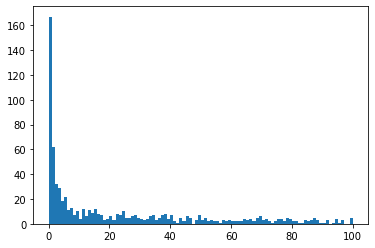

In [113]:
import matplotlib.pyplot as plt
plt.hist(total_ranks, bins = 100, range = [0, 100])
plt.savefig(birth_property+'_gptneo.jpg')
plt.show()

In [ ]:
# generator = pipeline('text-generation', model=model, tokenizer=tokenizer, device = 6)
# test_s = "1) Barack Obama was born in Honolulu.\n2) Angela Merkel was born in Berlin.\n3) John Lennon was born in liverpool\n4) Donald Trump was born in New York\n5) Joe Biden was born in Pennsylvania\n6) Clinton was born in"
# print(test_s)
# len(tokenizer.tokenize(test_s))
# generated = generator(test_s, do_sample=True, max_length=10)
# print(generated[0]["generated_text"])

# prompt = (
#     "In a shocking finding, scientists discovered a herd of unicorns living in a remote, "
#     "previously unexplored valley, in the Andes Mountains. Even more surprising to the "
#     "researchers was the fact that the unicorns spoke perfect English."
# )
# input_ids = tokenizer(prompt, return_tensors="pt").input_ids
# input_ids = input_ids.to(device)
# gen_output = model.generate(
#     input_ids,
#     # do_sample=True,
#     # temperature=0.9,
#     max_length=60,
#     return_dict_in_generate = True,
#     output_scores = True
# )
# gen_tokens = gen_output.sequences
# gen_scores = gen_output.scores
# gen_text = tokenizer.batch_decode(gen_tokens)[0]
# print(gen_text)